In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt

2024-04-23 20:41:55.040413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 20:41:55.040523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 20:41:55.179025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/twitter-sentiment-dataset/Twitter_Data.csv


In [2]:
data_path = pd.read_csv('/kaggle/input/twitter-sentiment-dataset/Twitter_Data.csv')
df = data_path
print(df)

                                               clean_text  category
0       when modi promised “minimum government maximum...      -1.0
1       talk all the nonsense and continue all the dra...       0.0
2       what did just say vote for modi  welcome bjp t...       1.0
3       asking his supporters prefix chowkidar their n...       1.0
4       answer who among these the most powerful world...       1.0
...                                                   ...       ...
162975  why these 456 crores paid neerav modi not reco...      -1.0
162976  dear rss terrorist payal gawar what about modi...      -1.0
162977  did you cover her interaction forum where she ...       0.0
162978  there big project came into india modi dream p...       0.0
162979  have you ever listen about like gurukul where ...       1.0

[162980 rows x 2 columns]


In [3]:
df['clean_text'].fillna('', inplace=True)
all_tweets = ' '.join(df['clean_text'])
# Tokenize words
tokenized_text = [word_tokenize(text.lower()) for text in df['clean_text']]

# Word2Vec model
model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# Most similar words
similar_words = model.wv.most_similar('happy', topn=5)

# Define input and target variables
X = df['clean_text']
y = df['category']

# Encode target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = utils.to_categorical(y)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Max sequence length
max_seq_length = max([len(seq) for seq in sequences])

# Pad sequences
X_pad = pad_sequences(sequences, maxlen=max_seq_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [5]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_shape=(max_seq_length,)))
model.add(SpatialDropout1D(0.5))
model.add(Bidirectional(LSTM(units=128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 52, 100)        │    11,368,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 52, 100)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 52, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 52, 64)         │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,660,548 (44.48 MB)

 Trainable params: 11,660,548 (44.48 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.1, callbacks=[reduce_lr, early_stop])

Epoch 1/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 122s 124ms/step - accuracy: 0.6778 - loss: 0.7336 - val_accuracy: 0.9447 - val_loss: 0.1921 - learning_rate: 0.0010
Epoch 2/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 112s 122ms/step - accuracy: 0.9428 - loss: 0.1823 - val_accuracy: 0.9613 - val_loss: 0.1240 - learning_rate: 0.0010
Epoch 3/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 113s 123ms/step - accuracy: 0.9652 - loss: 0.1096 - val_accuracy: 0.9705 - val_loss: 0.1085 - learning_rate: 0.0010
Epoch 4/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 111s 121ms/step - accuracy: 0.9745 - loss: 0.0820 - val_accuracy: 0.9694 - val_loss: 0.1079 - learning_rate: 0.0010
Epoch 5/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 111s 121ms/step - accuracy: 0.9785 - loss: 0.0682 - val_accuracy: 0.9646 - val_loss: 0.1222 - learning_rate: 0.0010
Epoch 6/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 111s 121ms/step - accuracy: 0.9822 - loss: 0.0567 - val_accuracy: 0.9658 - val_loss: 0.1253 - learning_rate: 0.0010
Epoch 7/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 111s 121ms/step - accura

In [7]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9654 - loss: 0.1186
Test Loss: 0.11093989759683609
Test Accuracy: 96.76%


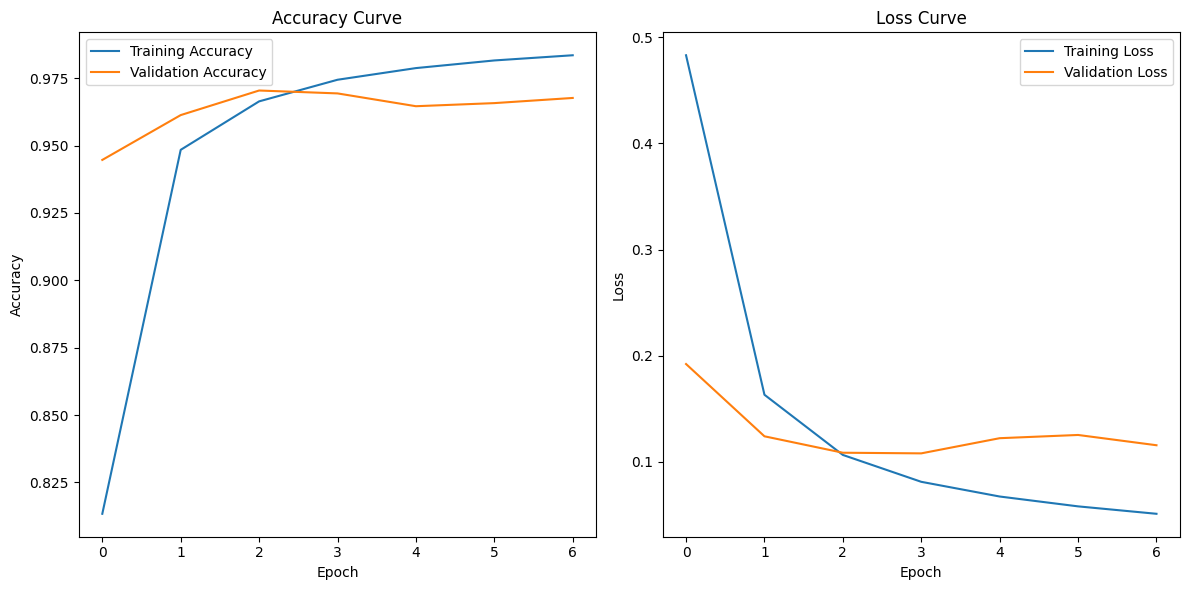

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

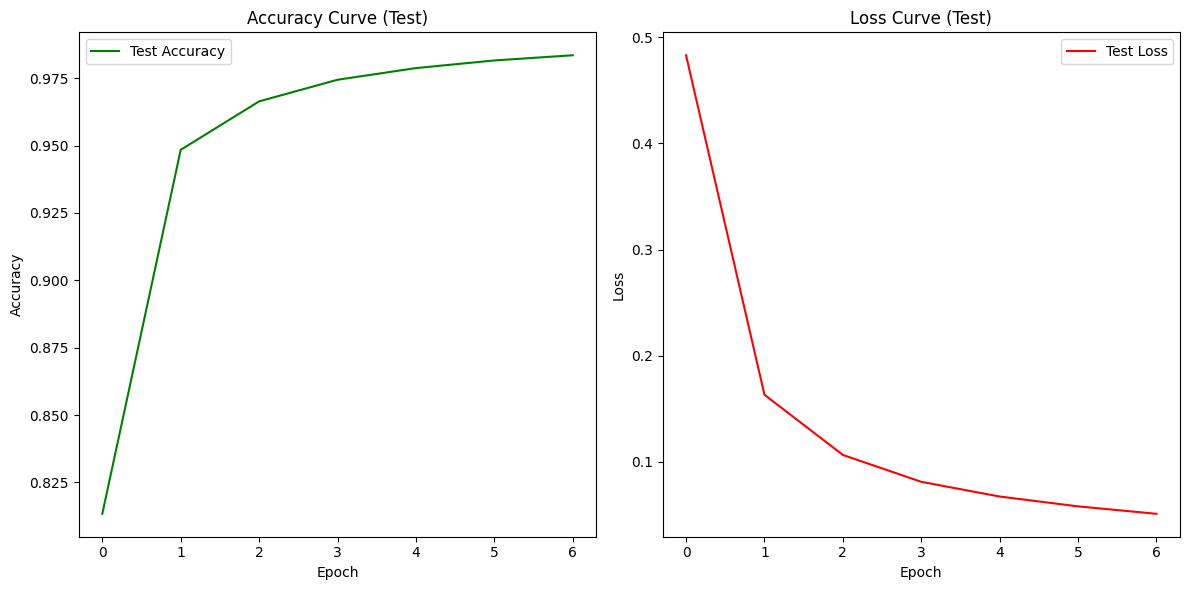

In [9]:
plt.figure(figsize=(12, 6))

# Plot Test Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Test Accuracy', color='green')
plt.title('Accuracy Curve (Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Test Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Test Loss', color='red')
plt.title('Loss Curve (Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
